In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Function to preprocess images
def preprocess_image(img_path):
    # Read image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Noise reduction using median filtering
    img = cv2.medianBlur(img, 3)
    
    # Resize to 224x224 (standard for CNNs)
    img = cv2.resize(img, (224, 224))
    
    # Normalize pixel values to [0, 1]
    img = img.astype('float32') / 255.0

    return img

In [3]:
def load_dataset():
    # Base directories
    train_dir = "/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"
    
    # Find the DOENTES and SAUDÁVEIS directories
    train_folders = os.listdir(train_dir)
    doentes_dir = os.path.join(train_dir, [folder for folder in train_folders if "DOENTES" in folder][0])
    saudaveis_dir = os.path.join(train_dir, [folder for folder in train_folders if "SAUD" in folder][0])
    
    # Function to load images from the "Segmentadas" subdirectories: This is to look for the image in the file
    def load_images_from_segmentadas(directory, label):
        images = []
        labels = []
        
        for root, dirs, files in os.walk(directory):
            # Only process files inside "Segmentadas" subdirectories
            if "Segmentadas" in root:
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    
                    # Skip non-image files
                    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        continue
                    
                    # Preprocess the image
                    img = preprocess_image(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        
        return images, labels 
        #label refer to 1 for cancerous images (from "DOENTES")
        #0 for healthy images (from "SAUDÁVEIS")
    
    # Load images from both directories
    print("Loading cancer (DOENTES) images...")
    cancer_images, cancer_labels = load_images_from_segmentadas(doentes_dir, 1)
    
    print("Loading healthy (SAUDÁVEIS) images...")
    healthy_images, healthy_labels = load_images_from_segmentadas(saudaveis_dir, 0)
    
    # Combine datasets
    all_images = cancer_images + healthy_images
    all_labels = cancer_labels + healthy_labels
    
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    # Print the shape before conversion
    print(f"Dataset shape before RGB conversion: {X.shape}")
    
    # Convert grayscale to RGB (duplicate channels)
    if X.ndim == 3:  #check for the shape
        # If shape is (n, 224, 224) -> this is grayscale  #n is the number of images x height x width (224 is convention)
        # If shape is (n, 224, 224,3)-> RGB with the ending 3 is the #channels
        X = np.stack([X, X, X], axis=-1) 
        #Since the original image is grayscale (with just one channel), 
        #stacking three copies for each image along the color channel, which is the last one.
        #after stacking the result is: (#images, #height, #width,3)
    
    # Print the shape after conversion
    print(f"Dataset shape after RGB conversion: {X.shape}")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test


In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2
# MobileNetV2 Model Configuration
def create_mobilenetv2_model(input_shape=(224, 224, 3)): #conventional input size for MobileNetv2- pre-trained model
    base_model = MobileNetV2(
        weights='imagenet', #pre-trained weight from imagenet
        include_top=False,  #Exclude the fully connected layers at the top (classification layers) of the MobileNetV2 model  
        input_shape=input_shape
    )
    
    # Freeze base layers initially to preserve useful feature 
    base_model.trainable = False
    # Optionally, freeze first few layers
    for layer in base_model.layers[:50]:
     layer.trainable = False
    
    model = Sequential([
        # Crucial scaling layer for medical images (converts [0-1] to MobileNet'required s [-1,1] range)
        tf.keras.Input(shape = input_shape),
        tf.keras.layers.Rescaling(2.0, offset=-1.0),
        base_model,
        GlobalAveragePooling2D(),#reduce feature map
        Dropout(0.5),  # Increased dropout for medical imaging robustness
        Dense(512, activation='relu',kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification (cancer vs healthy)
    ])
    
    return model


In [5]:
# Model Compilation with Medical Imaging Optimizations
model = create_mobilenetv2_model()
model.compile( #set up how the model will learn and be evaluated.
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
        #Shows how well the model separates positive from negative classes.
        #AUC = 1.0 → perfect classifier; AUC = 0.5 → random guess.
    ]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Medical Image Data Augmentation
med_augmentation = tf.keras.Sequential([ #create a pipeline of random change
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1)
])

# Create TensorFlow Dataset with Augmentation
X_train,X_test,y_train,y_test = load_dataset()
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) #Converts your NumPy arrays into a TensorFlow Dataset object,
train_dataset = train_dataset.shuffle(1000).batch(batch_size).map( #apply the augmentation to each batch, keep y the same label,
    lambda x, y: (med_augmentation(x, training=True), y),#define a function takes  2 arguments x, y
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Loading cancer (DOENTES) images...
Loading healthy (SAUDÁVEIS) images...
Dataset shape before RGB conversion: (1282, 224, 224)
Dataset shape after RGB conversion: (1282, 224, 224, 3)


In [7]:
# Class Weight Calculation for Imbalanced Medical Data
class_counts = np.bincount(y_train) # count how many of each class
total = len(y_train)
weight_for_0 = (1 / class_counts[0]) * (total / 2.0) #normalization step (2 is 2 classes)
weight_for_1 = (1 / class_counts[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1} #dictionary

In [8]:
# Training Configuration
checkpoint = ModelCheckpoint( #$save the model only when validation AUC improve
    'best_model.keras',
    monitor='val_auc', 
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_auc', #Stops training if val_auc doesn't improve for 10 epochs
    patience=10,
    mode='max',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    factor=0.2,          # Reduce LR by multiplying it with this factor
    patience=10,          # Number of epochs to wait before reducing LR
    verbose=1,
    min_lr=1e-6          # Minimum learning rate
)

In [9]:
!pip install pygad


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.9 MB/s eta 0:00:00


In [10]:
# Step 1: Import libraries
import pygad #Genetic Algorithms (GA).
from pygad import kerasga
import numpy as np
import tensorflow as tf

In [11]:
def create_model(learning_rate=0.0001, dropout_rate=0.49, fine_tune_layers=0):
    # Base MobileNetV2 model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # If fine-tuning is enabled, unfreeze some layers
    if fine_tune_layers > 0:
        # Ensure we don't try to unfreeze more layers than exist
        max_layers = len(base_model.layers)
        layers_to_unfreeze = min(fine_tune_layers, max_layers)
        
        # Unfreeze the last n layers
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True
    
    # Build the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
   
    x = Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3) (x)
    x = Dense(1024, activation='relu')(x)  # Added more neurons
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy', 
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5550 - auc: 0.5786 - loss: 7.8797 - precision: 0.5442 - recall: 0.5732
Epoch 1: val_auc improved from -inf to 0.89048, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 372ms/step - accuracy: 0.5558 - auc: 0.5799 - loss: 7.8740 - precision: 0.5449 - recall: 0.5742 - val_accuracy: 0.8132 - val_auc: 0.8905 - val_loss: 7.1420 - val_precision: 0.8067 - val_recall: 0.8643 - learning_rate: 1.0000e-04
Epoch 2/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6374 - auc: 0.7117 - loss: 7.1134 - precision: 0.6044 - recall: 0.6086
Epoch 2: val_auc improved from 0.89048 to 0.93855, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6425 - auc: 0.7168 - loss: 7.0966 - precision: 0.6113 - recall: 0.6168 - val_accuracy: 0.8677 - val_auc: 0.9386 - val_loss: 6.4378 - val_precision: 0.8155 - val_recall: 0.9786 - learning_rate: 1.0000e-04
Epoch 3/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 30m

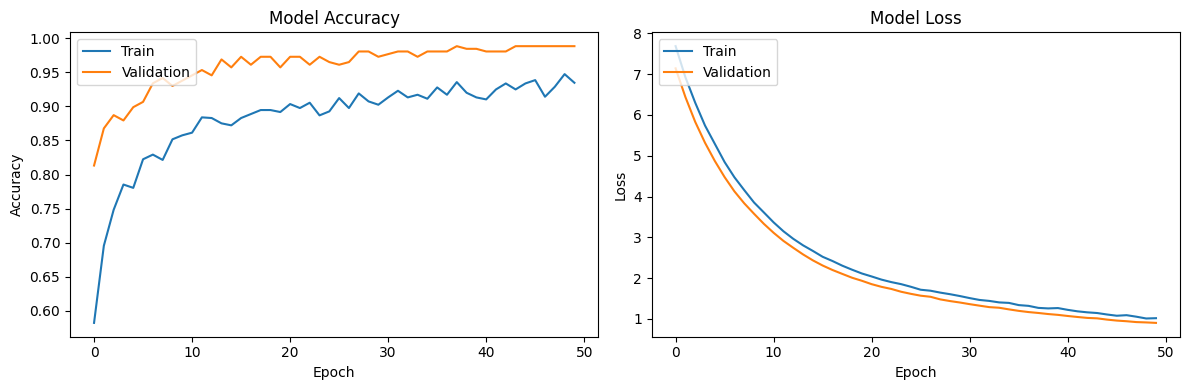

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9834 - auc: 0.9993 - loss: 0.9687 - precision: 1.0000 - recall: 0.9672
Test Loss: 0.9590
Test Accuracy: 0.9883
Test AUC: 0.9999
Test Precision: 1.0000
Test Recall: 0.9786
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       117
           1       1.00      0.98      0.99       140

    accuracy                           0.99       257
   macro avg       0.99      0.99      0.99       257
weighted avg       0.99      0.99      0.99       257



In [12]:
from sklearn.utils.class_weight import compute_class_weight #deal with imbalance
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report #precision, recall, f1-score, etc.


def train_standard_model():
    # Create model with default parameters
    model = create_model()
    
    # Calculate class weights for imbalanced dataset
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train.flatten()),
        y=y_train.flatten()
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_auc', mode='max', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    # Save model
    model.save('my_model.h5')
    # Plot results
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test AUC: {results[2]:.4f}")
    print(f"Test Precision: {results[3]:.4f}")
    print(f"Test Recall: {results[4]:.4f}")
    
    return model, history

# Train standard model
standard_model, standard_history = train_standard_model()
    # Get predictions and classification report
y_pred_probs = standard_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert to class labels
y_true = y_test

print(classification_report(y_true, y_pred, zero_division=1))


In [13]:
from sklearn.metrics import cohen_kappa_score

# Flatten the arrays if needed
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Calculate and print Cohen's Kappa
kappa = cohen_kappa_score(y_true_flat, y_pred_flat)
print(f"Cohen's Kappa: {kappa:.4f}")


Cohen's Kappa: 0.9765
